# Libraries

In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from ml_things import plot_dict, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump
from joblib import load
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Preprocessing

- <strong>count</strong>: number of CrowdFlower users who coded each tweet
- <strong>hate_speech</strong>: number of CF users who judged the tweet to be hate speech
- <strong>offensive_language</strong>: number of CF users who judged the tweet to be offensive
- <strong>neither</strong>: number of CF users who judged the tweet to be neither offensive nor non-offensive
- <strong>class</strong>: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
- <strong>tweet</strong>: text tweet

In [5]:
# Tensorboard initialization
writer = SummaryWriter(log_dir="./logs")

def parse_tweets_until_colon(data):
    parsed_tweets = []
    for tweet in data['tweet']:
        colon_index = tweet.find(':')
        if colon_index != -1:
            parsed_tweets.append(tweet[colon_index + 1:])
        else:
            parsed_tweets.append(tweet)
    return parsed_tweets

data = pd.read_csv('YD_aug_data_balanced.csv')
# data = data.drop(columns='Unnamed: 0')
# data['tweet'] = parse_tweets_until_colon(data)

# data = load_dataset('ucberkeley-dlab/measuring-hate-speech')
# data = data['train'].to_pandas()

data.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


# Text cleaning

- <strong>Lowercasing</strong>: Convert all text to lowercase to ensure uniformity.
- <strong>Removing Punctuation</strong>: Eliminate punctuation marks as they often don't carry much meaning in NLP tasks.
- <strong>Removing Special Characters</strong>: Remove special characters, emojis, URLs, etc., which may not contribute to the task at hand.
- <strong>Removing Stopwords</strong>: Stopwords are common words (e.g., "the", "is", "and") that occur frequently but often carry little information. Removing them can reduce noise in the data.

In [25]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

def clean_text(data):
    cleaned_tweets = []
    for tweet in data:
        tweet = tweet.lower()  # Convert text to lowercase
        tweet = re.sub(r"[^\w\s]", "", tweet)  # Remove punctuation
        tweet = re.sub(r"\d+", "", tweet)  # Remove numbers
        tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra whitespaces
        cleaned_tweets.append(tweet)
    return cleaned_tweets

def remove_stopwords(data):
    nostopwords_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        stop_words = set(stopwords.words("english"))
        filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        filtered_text = " ".join(filtered_tokens)  # Join tokens back into a string
        nostopwords_tweets.append(filtered_text)
    return nostopwords_tweets

def apply_stemming(data):
    stemmer = PorterStemmer()
    stemmed_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming
        stemmed_text = " ".join(stemmed_tokens)  # Join tokens back into a string
        stemmed_tweets.append(stemmed_text)
    return stemmed_tweets

def apply_lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Apply lemmatization
        lemmatized_text = " ".join(lemmatized_tokens)  # Join tokens back into a string
        lemmatized_tweets.append(lemmatized_text)
    return lemmatized_tweets

data["Content"] = clean_text(data["Content"])
data["Content"] = remove_stopwords(data["Content"])
data["Content"] = apply_stemming(data["Content"])
data["Content"] = apply_lemmatization(data["Content"])

data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


RecursionError: maximum recursion depth exceeded

## Split training/test set

- 80% → training set
- 20% → test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data["Content"], data["Label"], test_size=0.2, random_state=37)

# Model initialization


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPT-2
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set padding token to eos_token

model_config_gpt2 = GPT2Config.from_pretrained('gpt2', num_labels=3, pad_token_id=tokenizer_gpt2.pad_token_id)
model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(device)

#BERT
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

#LOGISTIC REGRESSION
vectorizer = CountVectorizer()

# Fit and transform the data
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ML: Logistic Regression

C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is de

Best params: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.832
Precision: 0.832
Recall: 0.832
F1 Score: 0.832
Confusion Matrix:
 [[60009 12178]
 [12256 60781]]
Classification Report:
              precision    recall  f1-score   support

     class 0       0.83      0.83      0.83     72187
     class 1       0.83      0.83      0.83     73037

    accuracy                           0.83    145224
   macro avg       0.83      0.83      0.83    145224
weighted avg       0.83      0.83      0.83    145224

Normalized confusion matrix


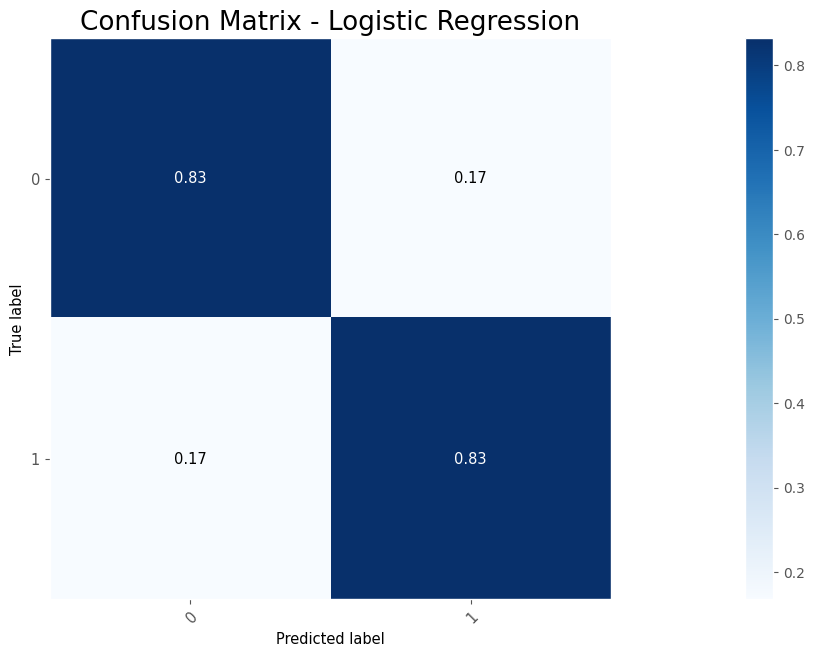

array([[0.83129926, 0.16870074],
       [0.16780536, 0.83219464]])

In [8]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

# Define the parameter grid
param_grid = {
    'C': [100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100]
}


# Perform GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the scaled training data
grid_search.fit(X_train_vect, y_train)

# Get the best model
best_logreg = grid_search.best_estimator_

# Evaluate the best model on the test set
logreg_pred = best_logreg.predict(X_test_vect)
#print("{} \n\n".format(X_test_vect))
# Print the best parameters and accuracy
print("Best params: {}".format(grid_search.best_params_))
print('Accuracy: {:.3f}'.format(accuracy_score(logreg_pred, y_test)))

# Save the best Logistic Regression model
dump(best_logreg, 'LogisticRegression_model.joblib')

# Analysis
precision = precision_score(y_test, logreg_pred, average='weighted')
recall = recall_score(y_test, logreg_pred, average='weighted')
f1 = f1_score(y_test, logreg_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, logreg_pred)

classes = sorted(set(y_test))

print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
print("Classification Report:")
print(classification_report(y_test, logreg_pred, target_names=['class 0', 'class 1']))
plot_confusion_matrix(y_true = y_test, y_pred = logreg_pred, classes=[0, 1], normalize=True, magnify=0.1, use_title="Confusion Matrix - Logistic Regression")

# GPT-2

The OpenAI GPT-2 (Generative Pre-Trained Transformer 2) is a transfomer-based language model. It's a standard model for NLP tasks.

Starting training: epochs - 3, lr - 1e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.413393204622654
Epoch 2: Average Loss: 0.327206625920455
Epoch 3: Average Loss: 0.2744880805843472
Training complete: epochs - 3, lr - 1e-05, batch size - 32
Starting training: epochs - 3, lr - 2e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.39784291656340526
Epoch 2: Average Loss: 0.3103976494560887
Epoch 3: Average Loss: 0.2333763245176525
Training complete: epochs - 3, lr - 2e-05, batch size - 32
Starting training: epochs - 4, lr - 1e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.41310818807675426
Epoch 2: Average Loss: 0.32650068970205753
Epoch 3: Average Loss: 0.2747613918678549
Epoch 4: Average Loss: 0.2154357728551375
Training complete: epochs - 4, lr - 1e-05, batch size - 32
Starting training: epochs - 4, lr - 2e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.3970551319329632
Epoch 2: Average Loss: 0.3098890057617243
Epoch 3: Average Loss: 0.23314874814057301
Epoch 4: Average Loss: 0.14455387388263016
Training complete: epochs - 4, lr - 2e-05, batch size - 32
Parameter tuning phase ended. Best parameters: epochs - 3, batch size - 32, lr - 2e-05

--- TRAINING WITH BEST PARAMETERS ---
GPT-2 Accuracy: 0.8630735966506914


C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


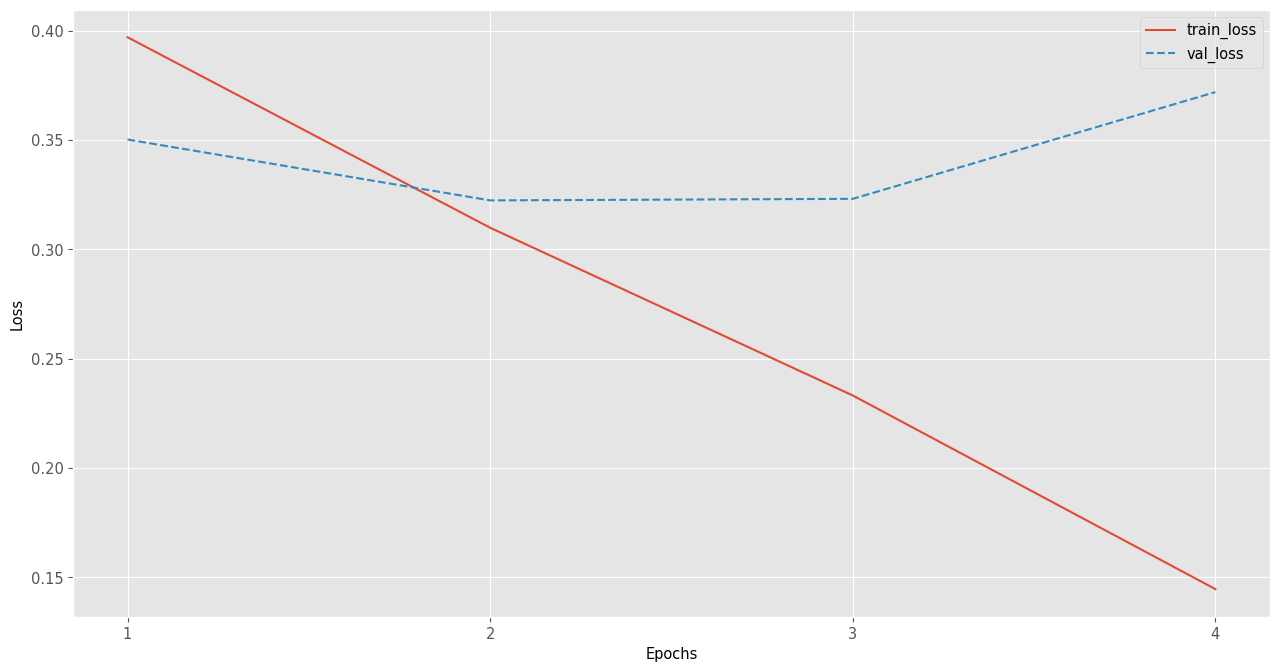

C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


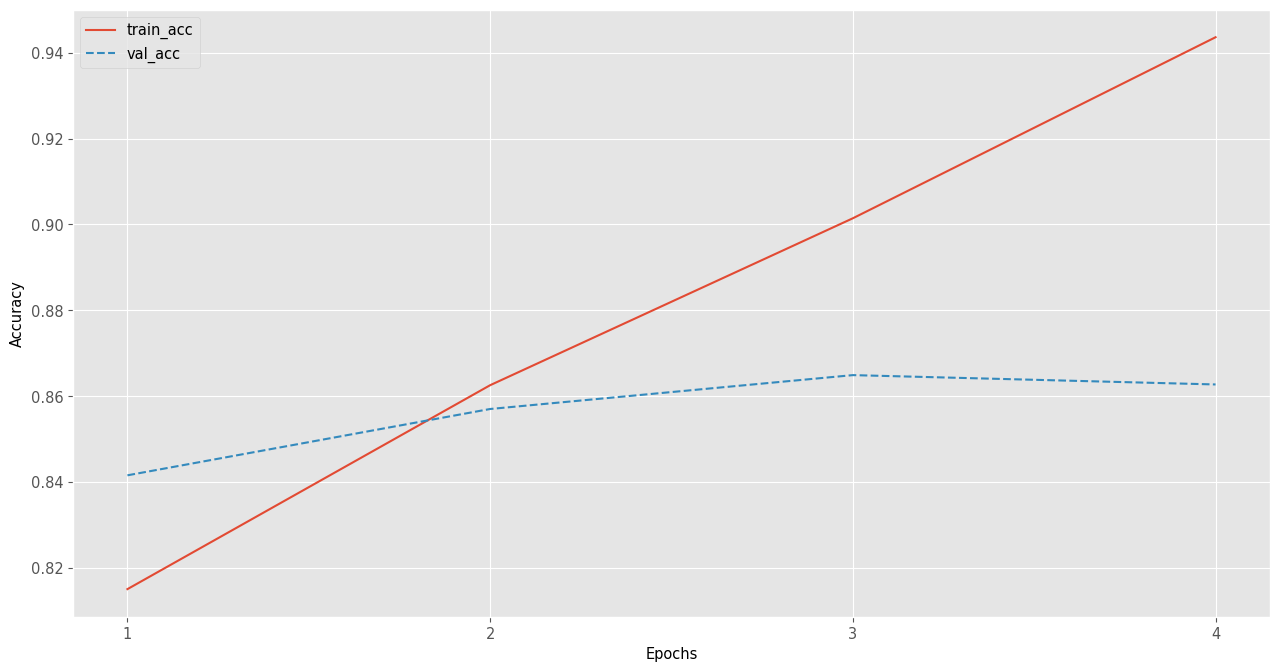

Classification Report:
              precision    recall  f1-score   support

     class 0       0.89      0.83      0.86     72187
     class 1       0.84      0.90      0.87     73037

    accuracy                           0.86    145224
   macro avg       0.86      0.86      0.86    145224
weighted avg       0.86      0.86      0.86    145224

Normalized confusion matrix


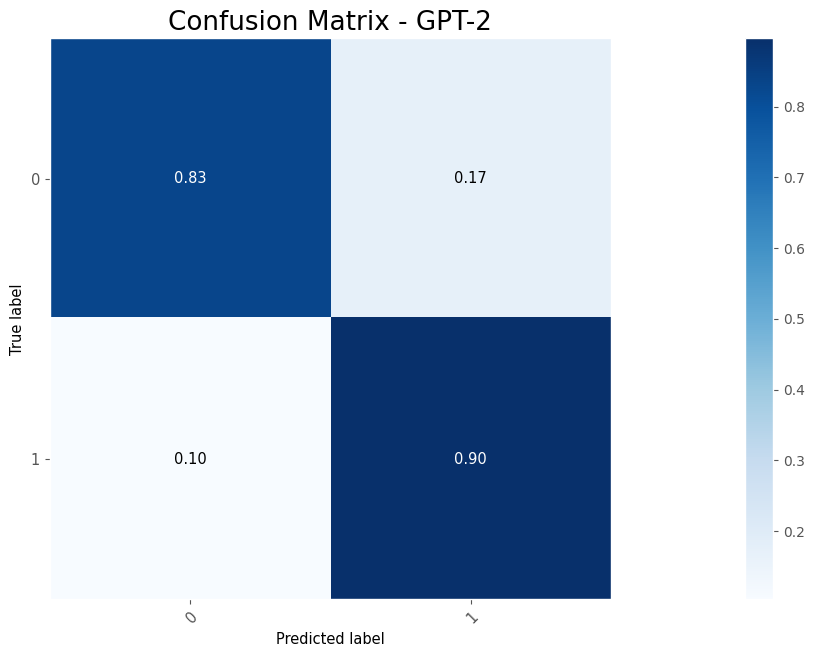

array([[0.82922133, 0.17077867],
       [0.10346811, 0.89653189]])

In [9]:
max_length = 32
tokenized_texts_train = tokenizer_gpt2(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
tokenized_texts_test = tokenizer_gpt2(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')


# Save tokenized data to disk
torch.save(tokenized_texts_train, 'tokenized_texts_train_gpt2.pth')  
torch.save(tokenized_texts_test, 'tokenized_texts_test_gpt2.pth')

labels_train = torch.tensor(list(y_train)).to(device)
labels_test = torch.tensor(list(y_test)).to(device)

train_dataset_gpt2 = TensorDataset(tokenized_texts_train.input_ids, tokenized_texts_train.attention_mask, labels_train)
test_dataset_gpt2 = TensorDataset(tokenized_texts_test.input_ids, tokenized_texts_test.attention_mask, labels_test)

model_config_gpt2 = GPT2Config.from_pretrained('gpt2', num_labels=3, pad_token_id=tokenizer_gpt2.pad_token_id)

def train_gpt2(model, epochs, lr, batch_size, device, save_model=False):
    all_loss_gpt2 = {'train_loss':[], 'val_loss':[]}
    all_acc_gpt2 = {'train_acc':[], 'val_acc':[]}
    train_loader_gpt2 = DataLoader(train_dataset_gpt2, batch_size=batch_size, shuffle=True)
    test_loader_gpt2 = DataLoader(test_dataset_gpt2, batch_size=batch_size, shuffle=False)
    optimizer = AdamW(model.parameters(), lr=lr, no_deprecation_warning=True)
    print(f"Starting training: epochs - {epochs}, lr - {lr}, batch size - {batch_size}")
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_correct_train = 0
        total_samples_train = 0
        for batch in train_loader_gpt2:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            writer.add_scalar("Loss/train_gpt2", loss, epoch)

            total_loss += loss.item()

            _, predicted_train = torch.max(outputs.logits, 1)
            total_samples_train += labels.size(0)
            total_correct_train += (predicted_train == labels).sum().item()

            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}: Average Loss: {total_loss / len(train_loader_gpt2)}')
        all_loss_gpt2['train_loss'].append(total_loss / len(train_loader_gpt2))
        all_acc_gpt2['train_acc'].append(total_correct_train / total_samples_train)
        model.eval()
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        with torch.no_grad():
            for batch in test_loader_gpt2:
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss = outputs.loss

                total_val_loss += val_loss.item()

                _, predicted_val = torch.max(outputs.logits, 1)
                total_samples_val += labels.size(0)
                total_correct_val += (predicted_val == labels).sum().item()
        
        all_loss_gpt2['val_loss'].append(total_val_loss / len(test_loader_gpt2))
        all_acc_gpt2['val_acc'].append(total_correct_val / total_samples_val)
        writer.add_scalar("Loss/val_gpt2", total_val_loss / len(test_loader_gpt2), epoch)

        if save_model:
            torch.save(model.state_dict(), 'gpt2_model.pth') # saving gpt-2 model
        writer.flush()
    print(f"Training complete: epochs - {epochs}, lr - {lr}, batch size - {batch_size}")
    return model, all_loss_gpt2, all_acc_gpt2

param_grid = {
    'batch_size': [32],
    'epochs': [3, 4],
    'lr': [1e-5, 2e-5]
}
best_params = None
best_accuracy = 0.0
best_model = None

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for lr in param_grid['lr']:
            model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(device)
            model_gpt2.resize_token_embeddings(len(tokenizer_gpt2))

            model_gpt2, all_loss_gpt2, all_acc_gpt2 = train_gpt2(model=model_gpt2, epochs=epochs, batch_size=batch_size, lr=lr, device=device)

            val_accuracy = all_acc_gpt2['val_acc'][-1]

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': lr}
                best_model = model_gpt2

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_learning_rate = best_params['lr']

print(f"Parameter tuning phase ended. Best parameters: epochs - {best_epochs}, batch size - {best_batch_size}, lr - {best_learning_rate}")
print("\n--- TRAINING WITH BEST PARAMETERS ---")
# Train the model with the best parameters
# model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(device)
# model_gpt2.resize_token_embeddings(len(tokenizer_gpt2))
# optimizer_gpt2 = AdamW(model_gpt2.parameters(), lr=best_learning_rate)

# model_gpt2, all_loss_gpt2, all_acc_gpt2 = train_gpt2(model=model_gpt2,  epochs=best_epochs, batch_size=best_batch_size, lr=best_learning_rate, device=device, save_model=True)

best_model.eval()
predicted_labels_gpt2 = []
true_labels_gpt2 = []

test_loader_gpt2 = DataLoader(test_dataset_gpt2, batch_size=best_batch_size, shuffle=False)

with torch.no_grad():
    for batch in test_loader_gpt2:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predicted_labels_gpt2.extend(torch.argmax(logits, axis=1).tolist()) #Extract the max logits value and convert from pytorch to a pyList
        true_labels_gpt2.extend(labels.tolist())

accuracy_gpt2 = accuracy_score(true_labels_gpt2, predicted_labels_gpt2)
print(f'GPT-2 Accuracy: {accuracy_gpt2}')

plot_dict(all_loss_gpt2, use_xlabel='Epochs', use_ylabel='Loss', use_linestyles=['-', '--'])
plot_dict(all_acc_gpt2, use_xlabel='Epochs', use_ylabel='Accuracy', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_gpt2, predicted_labels_gpt2, target_names=['class 0', 'class 1']))

plot_confusion_matrix(y_true=true_labels_gpt2, y_pred=predicted_labels_gpt2, classes=[0, 1], normalize=True, magnify=0.1, use_title="Confusion Matrix - GPT-2")

# BERT

BERT (Bidirectional Encoder Representations from Transformers) was developed by Google researchers.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 3, lr - 1e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.2991565973098525
Epoch 2: Average Loss: 0.171629166095681
Epoch 3: Average Loss: 0.07674940753107269
Training complete: epochs - 3, lr - 1e-05, batch size - 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 3, lr - 2e-05, batch size - 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.28514975978520524
Epoch 2: Average Loss: 0.15475332684541376
Epoch 3: Average Loss: 0.07103878477594286
Training complete: epochs - 3, lr - 2e-05, batch size - 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 4, lr - 1e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.30084973843338825
Epoch 2: Average Loss: 0.1720052635570014
Epoch 3: Average Loss: 0.07689200653826742
Epoch 4: Average Loss: 0.03985908249485735
Training complete: epochs - 4, lr - 1e-05, batch size - 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training: epochs - 4, lr - 2e-05, batch size - 32


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.28664515033058113
Epoch 2: Average Loss: 0.15616675056831106
Epoch 3: Average Loss: 0.07214066420716482
Epoch 4: Average Loss: 0.04423443850025747
Training complete: epochs - 4, lr - 2e-05, batch size - 32
Parameter tuning phase ended. Best parameters: epochs - 4, batch size - 32, lr - 2e-05

--- TRAINING WITH BEST PARAMETERS ---
BERT Accuracy: 0.9148556712389136


C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


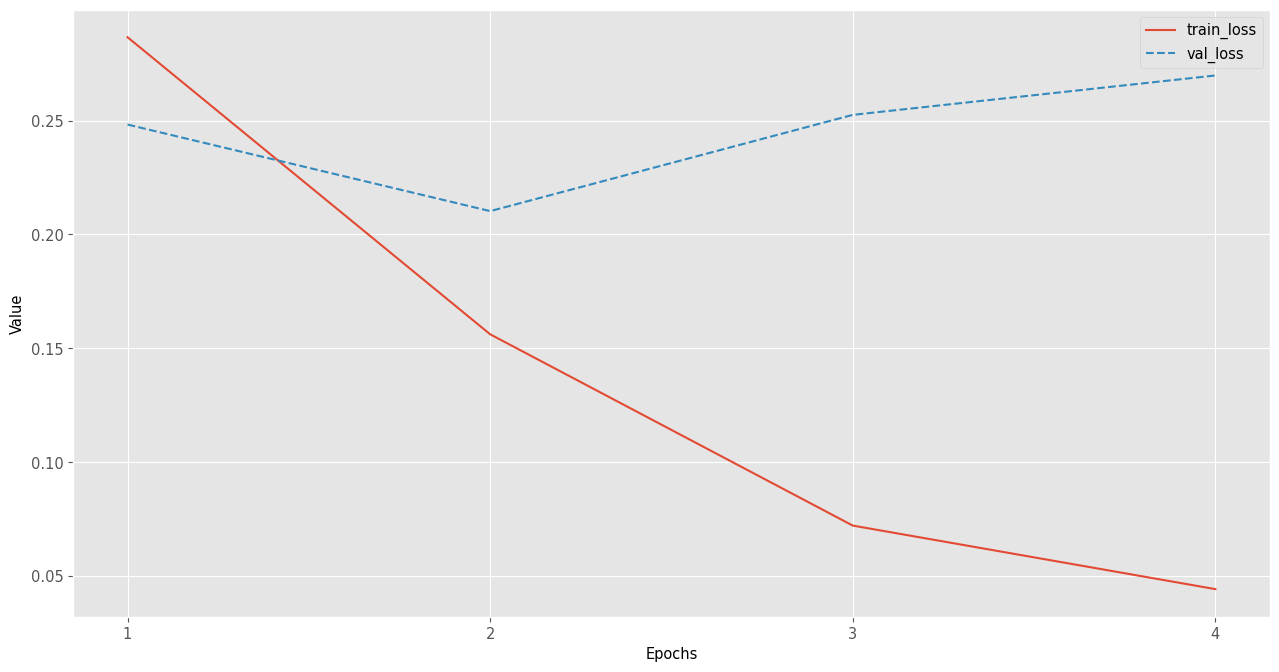

C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


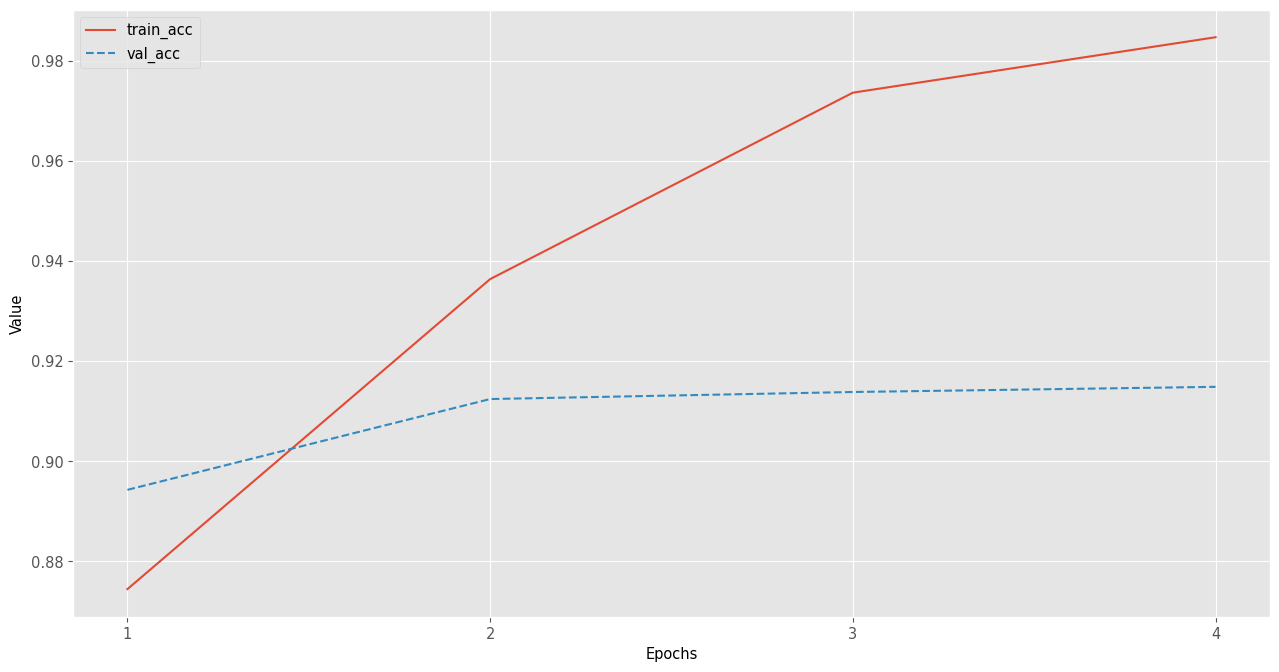

Classification Report:
              precision    recall  f1-score   support

     class 0       0.93      0.90      0.91     72187
     class 1       0.90      0.93      0.92     73037

    accuracy                           0.91    145224
   macro avg       0.92      0.91      0.91    145224
weighted avg       0.92      0.91      0.91    145224

Normalized confusion matrix


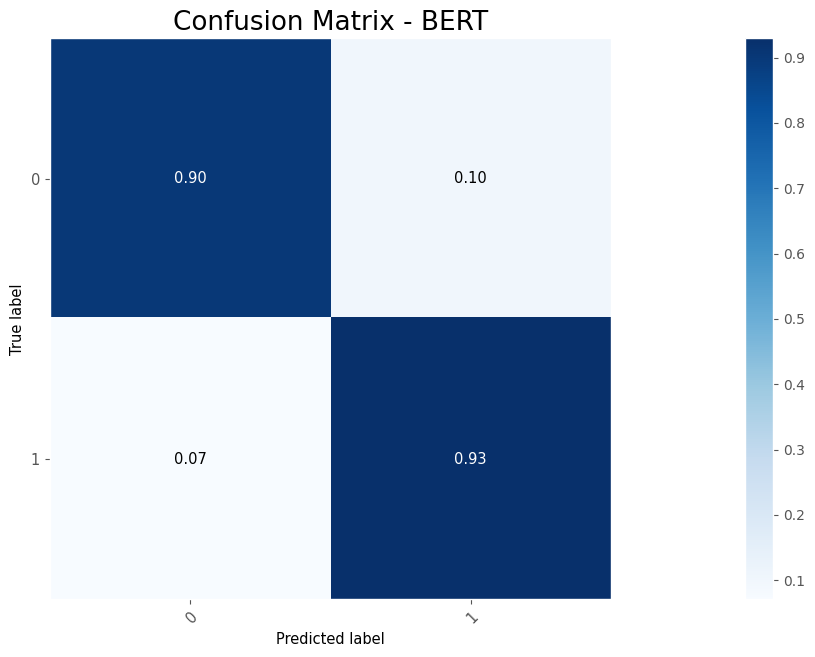

array([[0.89999584, 0.10000416],
       [0.07045744, 0.92954256]])

In [10]:
max_length = 32
tokenized_texts_train_bert = tokenizer_bert(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
tokenized_texts_test_bert = tokenizer_bert(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Save tokenized data to disk
torch.save(tokenized_texts_train_bert, 'tokenized_texts_train_bert.pth')  
torch.save(tokenized_texts_test_bert, 'tokenized_texts_test_bert.pth')

labels_train = torch.tensor(list(y_train)).to(device)
labels_test = torch.tensor(list(y_test)).to(device)

train_dataset_bert = TensorDataset(tokenized_texts_train_bert.input_ids, tokenized_texts_train_bert.attention_mask, labels_train)
test_dataset_bert = TensorDataset(tokenized_texts_test_bert.input_ids, tokenized_texts_test_bert.attention_mask, labels_test)

def train_bert(model, epochs, lr, batch_size, device, save_model=False):
    all_loss_bert = {'train_loss':[], 'val_loss':[]}
    all_acc_bert = {'train_acc':[], 'val_acc':[]}
    train_loader_bert = DataLoader(train_dataset_bert, batch_size=batch_size, shuffle=True)
    test_loader_bert = DataLoader(test_dataset_bert, batch_size=batch_size, shuffle=False)
    optimizer = AdamW(model.parameters(), lr=lr, no_deprecation_warning=True)
    print(f"Starting training: epochs - {epochs}, lr - {lr}, batch size - {batch_size}")
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_correct_train = 0
        total_samples_train = 0
        for batch in train_loader_bert:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            writer.add_scalar("Loss/train_bert", loss, epoch)
            total_loss += loss.item()

            _, predicted_train = torch.max(outputs.logits, 1)
            total_samples_train += labels.size(0)
            total_correct_train += (predicted_train == labels).sum().item()
            
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(train_loader_bert)
        print(f'Epoch {epoch + 1}: Average Loss: {avg_loss}')
        all_loss_bert['train_loss'].append(total_loss / len(train_loader_bert))
        all_acc_bert['train_acc'].append(total_correct_train / total_samples_train)
        model.eval()
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        with torch.no_grad():
            for batch in test_loader_bert:
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss = outputs.loss

                total_val_loss += val_loss.item()

                _, predicted_val = torch.max(outputs.logits, 1)
                total_samples_val += labels.size(0)
                total_correct_val += (predicted_val == labels).sum().item()

        all_loss_bert['val_loss'].append(total_val_loss / len(test_loader_bert))
        all_acc_bert['val_acc'].append(total_correct_val / total_samples_val)
        writer.add_scalar("Loss/val_bert", total_val_loss / len(test_loader_bert), epoch)

        if save_model:
            torch.save(model.state_dict(), 'bert_model.pth') # saving bert model
        writer.flush()
    print(f"Training complete: epochs - {epochs}, lr - {lr}, batch size - {batch_size}")
    return model, all_loss_bert, all_acc_bert

param_grid = {
    'batch_size': [32],
    'epochs': [3, 4],
    'lr': [1e-5, 2e-5]
}
best_params = None
best_accuracy = 0.0
best_model = None

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for lr in param_grid['lr']:
            model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
            model_bert.resize_token_embeddings(len(tokenizer_bert))

            model_bert, all_loss_bert, all_acc_bert = train_bert(model=model_bert, epochs=epochs, batch_size=batch_size, lr=lr, device=device)

            val_accuracy = all_acc_bert['val_acc'][-1]

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': lr}
                best_model = model_bert

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_learning_rate = best_params['lr']

print(f"Parameter tuning phase ended. Best parameters: epochs - {best_epochs}, batch size - {best_batch_size}, lr - {best_learning_rate}")
print("\n--- TRAINING WITH BEST PARAMETERS ---")
# model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
# model_bert.resize_token_embeddings(len(tokenizer_bert))
# optimizer_bert = AdamW(model_bert.parameters(), lr=best_learning_rate, no_deprecation_warning=True)

# model_bert, all_loss_bert, all_acc_bert = train_bert(model=model_bert, epochs=best_epochs, batch_size=best_batch_size, lr=best_learning_rate, device=device, save_model=True)

best_model.eval()
predicted_labels_bert = []
true_labels_bert = []

test_loader_bert = DataLoader(test_dataset_bert, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch in test_loader_bert:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels_bert.extend(torch.argmax(logits, axis=1).tolist())
        true_labels_bert.extend(labels.tolist())

accuracy_bert = accuracy_score(true_labels_bert, predicted_labels_bert)
print(f'BERT Accuracy: {accuracy_bert}')

plot_dict(all_loss_bert, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc_bert, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_bert, predicted_labels_bert, target_names=['class 0', 'class 1']))

plot_confusion_matrix(y_true=true_labels_bert, y_pred=predicted_labels_bert, classes=[0, 1], normalize=True, magnify=0.1, use_title="Confusion Matrix - BERT")


# Testing on some sentences

In [65]:
input_sentences = ["Fuck you and your entire country stupid French","Hi how are you?","weather is wonderful today", "fucking bitch you are so stupid", "go back to africa nigga", "stupid autistic nigga", "you are a beatiful butterfly", "The dishes at the belzoni restourant are good", "Stupid goat", "I'm dreaming that a bomb fall in your city", "Son of bitch", "love you son of a bitch"]

messages = ["hate speech", "offensive language", "message approved"]

preprocessed_input_sentences = clean_text(input_sentences)
preprocessed_input_sentences = remove_stopwords(preprocessed_input_sentences)
preprocessed_input_sentences = apply_stemming(preprocessed_input_sentences)
preprocessed_input_sentences = apply_lemmatization(preprocessed_input_sentences)


#model_gpt2.load_state_dict(torch.load('gpt2_model.pth', map_location = device))  # Load pre-trained GPT-2 model from disk
#model_bert.load_state_dict(torch.load('bert_model.pth', map_location = device))  # Load pre-trained BERT model from disk
model_LR = load('LogisticRegression_model.joblib')

with open("accuracy_bert.txt", "r") as file:
    accuracy_bert = float(file.read())

with open("accuracy_gpt2.txt", "r") as file:
    accuracy_gpt2 = float(file.read())

with open("accuracy_LR.txt", "r") as file:
    accuracy_LR = float(file.read())


# LOGISTIC REGRESSION

# Transform the input sentences
input_LR = vectorizer.transform(preprocessed_input_sentences)

predicted_classes_LR = []
for row in input_LR:
    # Reshape the row to be a 2D array
    row = row.reshape(1, -1)

    # Make prediction
    predicted_class_LR = model_LR.predict(row)
    predicted_classes_LR.append(predicted_class_LR)



for original_sentence, input_sentence, row in zip(input_sentences, preprocessed_input_sentences, input_LR):
    print(f"Input: {original_sentence}")

    # LOGISTIC REGRESSION
    # Reshape the row to be a 2D array
    row = row.reshape(1, -1)

    # Make prediction
    predicted_class_LR = (model_LR.predict(row))[0]
    print(f"LOGISTIC REGRESSION: Response: Class {predicted_class_LR} - {messages[predicted_class_LR]}")

    
    # BERT

    # Tokenize input for BERT
    input_ids_bert = tokenizer_bert.encode(input_sentence, return_tensors='pt').to(device)
    attention_mask_bert = torch.ones_like(input_ids_bert).to(device)

    # Generate output for BERT
    with torch.no_grad():
        outputs_bert = model_bert(input_ids_bert, attention_mask=attention_mask_bert)
        predicted_class_bert = torch.argmax(outputs_bert.logits, dim=1).item()

    print(f"BERT Response: Class {predicted_class_bert} - {messages[predicted_class_bert]}")

    # GPT-2

    # Tokenize input for GPT-2
    input_ids_gpt2 = tokenizer_gpt2.encode(input_sentence, return_tensors='pt').to(device)
    attention_mask_gpt2 = torch.ones_like(input_ids_gpt2).to(device)

    # Generate output for GPT-2
    with torch.no_grad():
        outputs_gpt2 = model_gpt2(input_ids_gpt2, attention_mask=attention_mask_gpt2)
        predicted_class_gpt2 = torch.argmax(outputs_gpt2.logits, dim=1).item()

    print(f"GPT-2 Response: Class {predicted_class_gpt2} - {messages[predicted_class_gpt2]}\n")

    
    

    # Multi-agent system: GPT-2 and BERT cooperate to guarantee a correct solution, based on their accuracy
    predicted_class_coop = (predicted_class_bert * accuracy_bert + predicted_class_gpt2 * accuracy_gpt2 + predicted_class_LR * accuracy_LR) / (accuracy_gpt2 + accuracy_bert + accuracy_LR)
    print(f"Cooperative result: Class {predicted_class_coop:.3f} - {messages[round(predicted_class_coop)]}\n")



Input: Fuck you and your entire country stupid French
LOGISTIC REGRESSION: Response: Class 1 - offensive language
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 2 - message approved

Cooperative result: Class 0.995 - offensive language

Input: Hi how are you?
LOGISTIC REGRESSION: Response: Class 1 - offensive language
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 0 - hate speech

Cooperative result: Class 0.333 - hate speech

Input: weather is wonderful today
LOGISTIC REGRESSION: Response: Class 2 - message approved
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 1 - offensive language

Cooperative result: Class 0.997 - offensive language

Input: fucking bitch you are so stupid
LOGISTIC REGRESSION: Response: Class 1 - offensive language
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 2 - message approved

Cooperative result: Class 0.995 - offensive language

Input: go back to africa nigga
LOGISTIC REGRESSION: Response: Class 1 - offensive 

# Plot

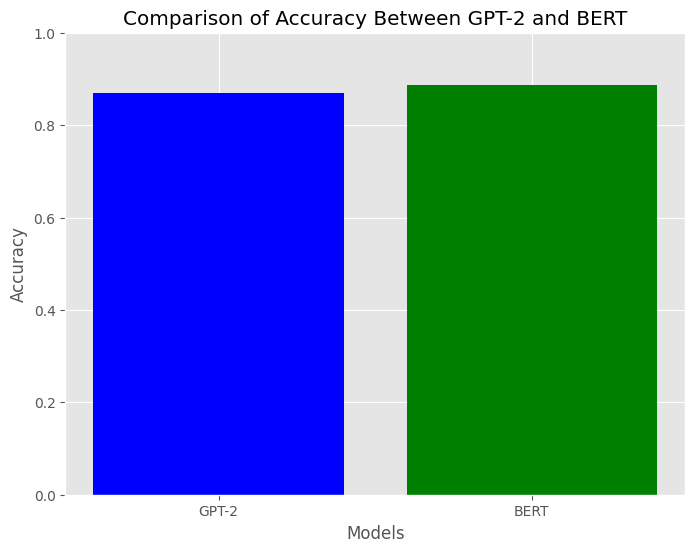

In [8]:
models = ['GPT-2', 'BERT']
accuracies = [accuracy_gpt2, accuracy_bert]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Between GPT-2 and BERT')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.show()